#**Importing libraries**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from statistics import mean
%matplotlib inline

# **Loading data**

In [ ]:
df = pd.read_csv("/content/logatta.csv")

#**Data Exploration and Preprocessing**

In [ ]:
df.head()

,Age,BusinessTravel,Education,MaritalStatus,OverTime,EmployeeNumber,DailyRate,Gender,accepted for the interview
0,41,Travel_Rarely,2,Single,Yes,1,1102,Female,True
1,49,Travel_Frequently,1,Married,No,2,279,Male,False
2,37,Travel_Rarely,2,Single,Yes,4,1373,Male,False
3,33,Travel_Frequently,4,Married,Yes,5,1392,Female,False
4,27,Travel_Rarely,1,Married,No,7,591,Male,False


In [ ]:
df.shape

(1492, 9)

In [ ]:
df.duplicated().sum()

0

There are 0 duplicate rows in the dataset.

In [ ]:
df.isnull().sum()

Age                           0
BusinessTravel                0
Education                     0
MaritalStatus                 0
OverTime                      0
EmployeeNumber                0
DailyRate                     0
Gender                        0
accepted for the interview    0
dtype: int64

There are not missing values.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Age                         1492 non-null   int64 
 1   BusinessTravel              1492 non-null   object
 2   Education                   1492 non-null   int64 
 3   MaritalStatus               1492 non-null   object
 4   OverTime                    1492 non-null   object
 5   EmployeeNumber              1492 non-null   int64 
 6   DailyRate                   1492 non-null   int64 
 7   Gender                      1492 non-null   object
 8   accepted for the interview  1492 non-null   bool  
dtypes: bool(1), int64(4), object(4)
memory usage: 94.8+ KB


All the features in dataset are numeric, with the exception of 'accepted for the interview', which is a boolean datatype.

In [ ]:
df['accepted for the interview'] = df['accepted for the interview'].astype(int)

 However, for the ease of analysis and to ensure compatibility with certain machine learning algorithms, this column was converted to an integer representation."

In [ ]:
# List of columns to one-hot encode
cols_to_encode = ['BusinessTravel', 'MaritalStatus', 'OverTime', 'Gender']

# One-hot encode these columns
df = pd.get_dummies(df, columns=cols_to_encode, drop_first=True)

# Display the resulting dataframe
df


,Age,Education,EmployeeNumber,DailyRate,accepted for the interview,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,Gender_Male
0,41,2,1,1102,1,0,1,0,1,1,0
1,49,1,2,279,0,1,0,1,0,0,1
2,37,2,4,1373,0,0,1,0,1,1,1
3,33,4,5,1392,0,1,0,1,0,1,0
4,27,1,7,591,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1487,35,3,1856,682,0,0,1,1,0,1,1
1488,35,4,1857,1103,0,0,1,0,0,0,1
1489,31,3,1858,976,0,0,1,0,1,1,1
1490,37,4,1859,1351,0,0,1,0,1,0,0


After one-hot encoding, the categorical variables 'BusinessTravel', 'MaritalStatus', 'OverTime', and 'Gender' have been transformed into binary columns. This step ensures that our machine learning models can utilize the information from these categorical attributes effectively without any datatype conflicts. By dropping the first column for each encoded variable, we also minimize the risk of multicollinearity.

In [ ]:
df.describe()

,Age,Education,EmployeeNumber,DailyRate,accepted for the interview,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,Gender_Male
count,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000,1492.000000
mean,36.885389,2.916220,1036.963137,804.987936,0.105228,0.188338,0.709786,0.457105,0.320375,0.282172,0.598525
std,9.102789,1.021738,605.700269,403.804253,0.306950,0.391113,0.454013,0.498324,0.466777,0.450207,0.490361
min,18.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,2.000000,496.750000,466.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,36.000000,3.000000,1034.500000,804.500000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,43.000000,4.000000,1581.250000,1162.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,60.000000,5.000000,2068.000000,1499.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
corr = df.corr()
target_corr = corr["accepted for the interview"].drop("accepted for the interview")

target_corr_sorted = target_corr.sort_values(ascending=False)

<Axes: >

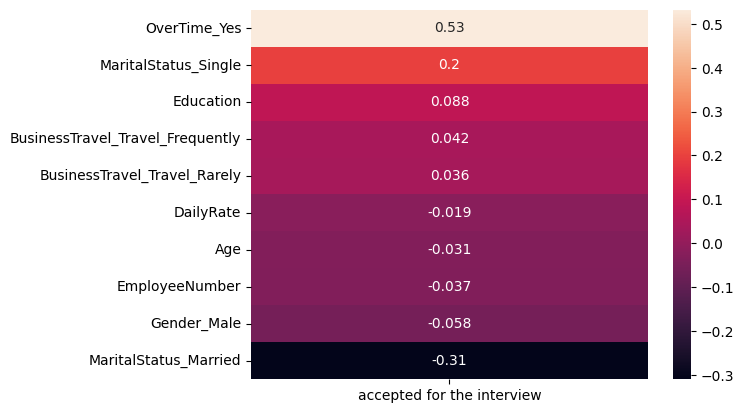

In [ ]:
sns.heatmap(target_corr_sorted.to_frame(), annot=True)

OverTime_Yes: A strong positive dependency (0.53) suggests that candidates who work overtime are considerably more likely to be accepted for the interview.

MaritalStatus_Single: A moderate positive dependency (0.2) indicates that single candidates have a higher likelihood of being accepted for the interview compared to their counterparts.

Education: A slight positive correlation (0.088) suggests that higher education levels might have a small influence on the acceptance rate for the interview.

BusinessTravel_Travel_Frequently and BusinessTravel_Travel_Rarely: Both have positive dependencies of 0.042 and 0.036 respectively, suggesting that candidates who travel, either frequently or rarely, have a somewhat higher chance of being accepted for the interview compared to those who don't travel for business.

DailyRate, Age, EmployeeNumber, and Gender_Male: These features show negative dependencies, but the values are quite small, indicating they have a very slight inverse relationship with the acceptance rate. For instance, male candidates (as indicated by Gender_Male) have a slightly lower chance of being accepted.

MaritalStatus_Married: A significant negative dependency (-0.31) suggests that married candidates are notably less likely to be accepted for the interview compared to other marital statuses.



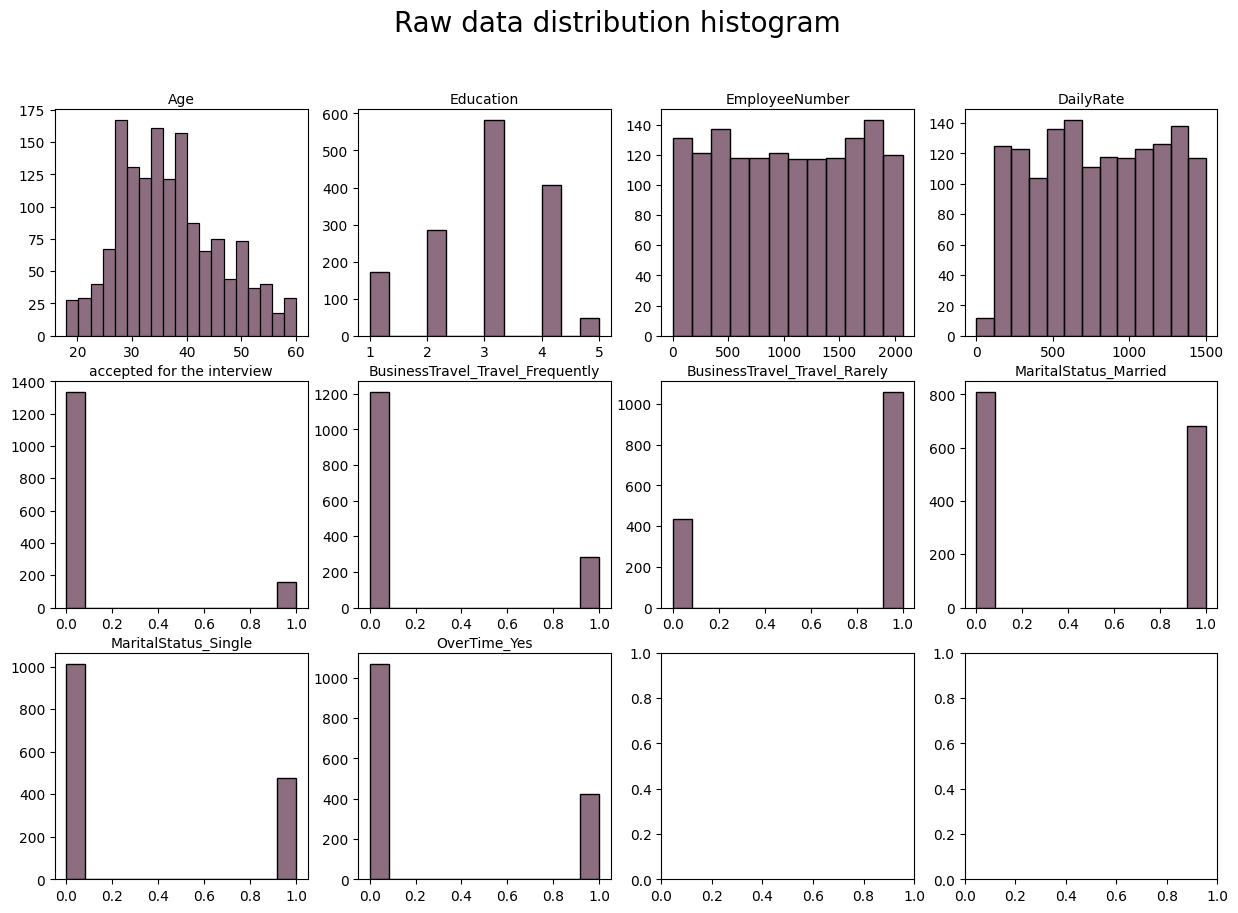

In [ ]:
n_rows, n_cols = 3, 4
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 10))
fig.suptitle('Raw data distribution histogram', fontsize=20)
for i, column in enumerate(df.columns[:-1]):
    sns.histplot(df[column],ax=axes[i//n_cols,i%n_cols], color = "#673d57")
    axes[i//n_cols,i%n_cols].xaxis.set_label_position('top')
    axes[i//n_cols,i%n_cols].set(ylabel=None)

For the "OverTime_Yes" feature, the histogram reveals that there are approximately two times as many employees who don't work overtime (0 value) compared to those who do.

Similarly, for "MaritalStatus_Single", there are approximately two times as many employees who are not single as opposed to those who are.

The histogram for "BusinessTravel_Travel_Frequently" reveals that the frequency of the value 0 (i.e., employees who do not travel frequently) is approximately 4 times higher than the value 1 (i.e., employees who travel frequently). This indicates that a vast majority of employees in the dataset do not travel frequently for business purposes.

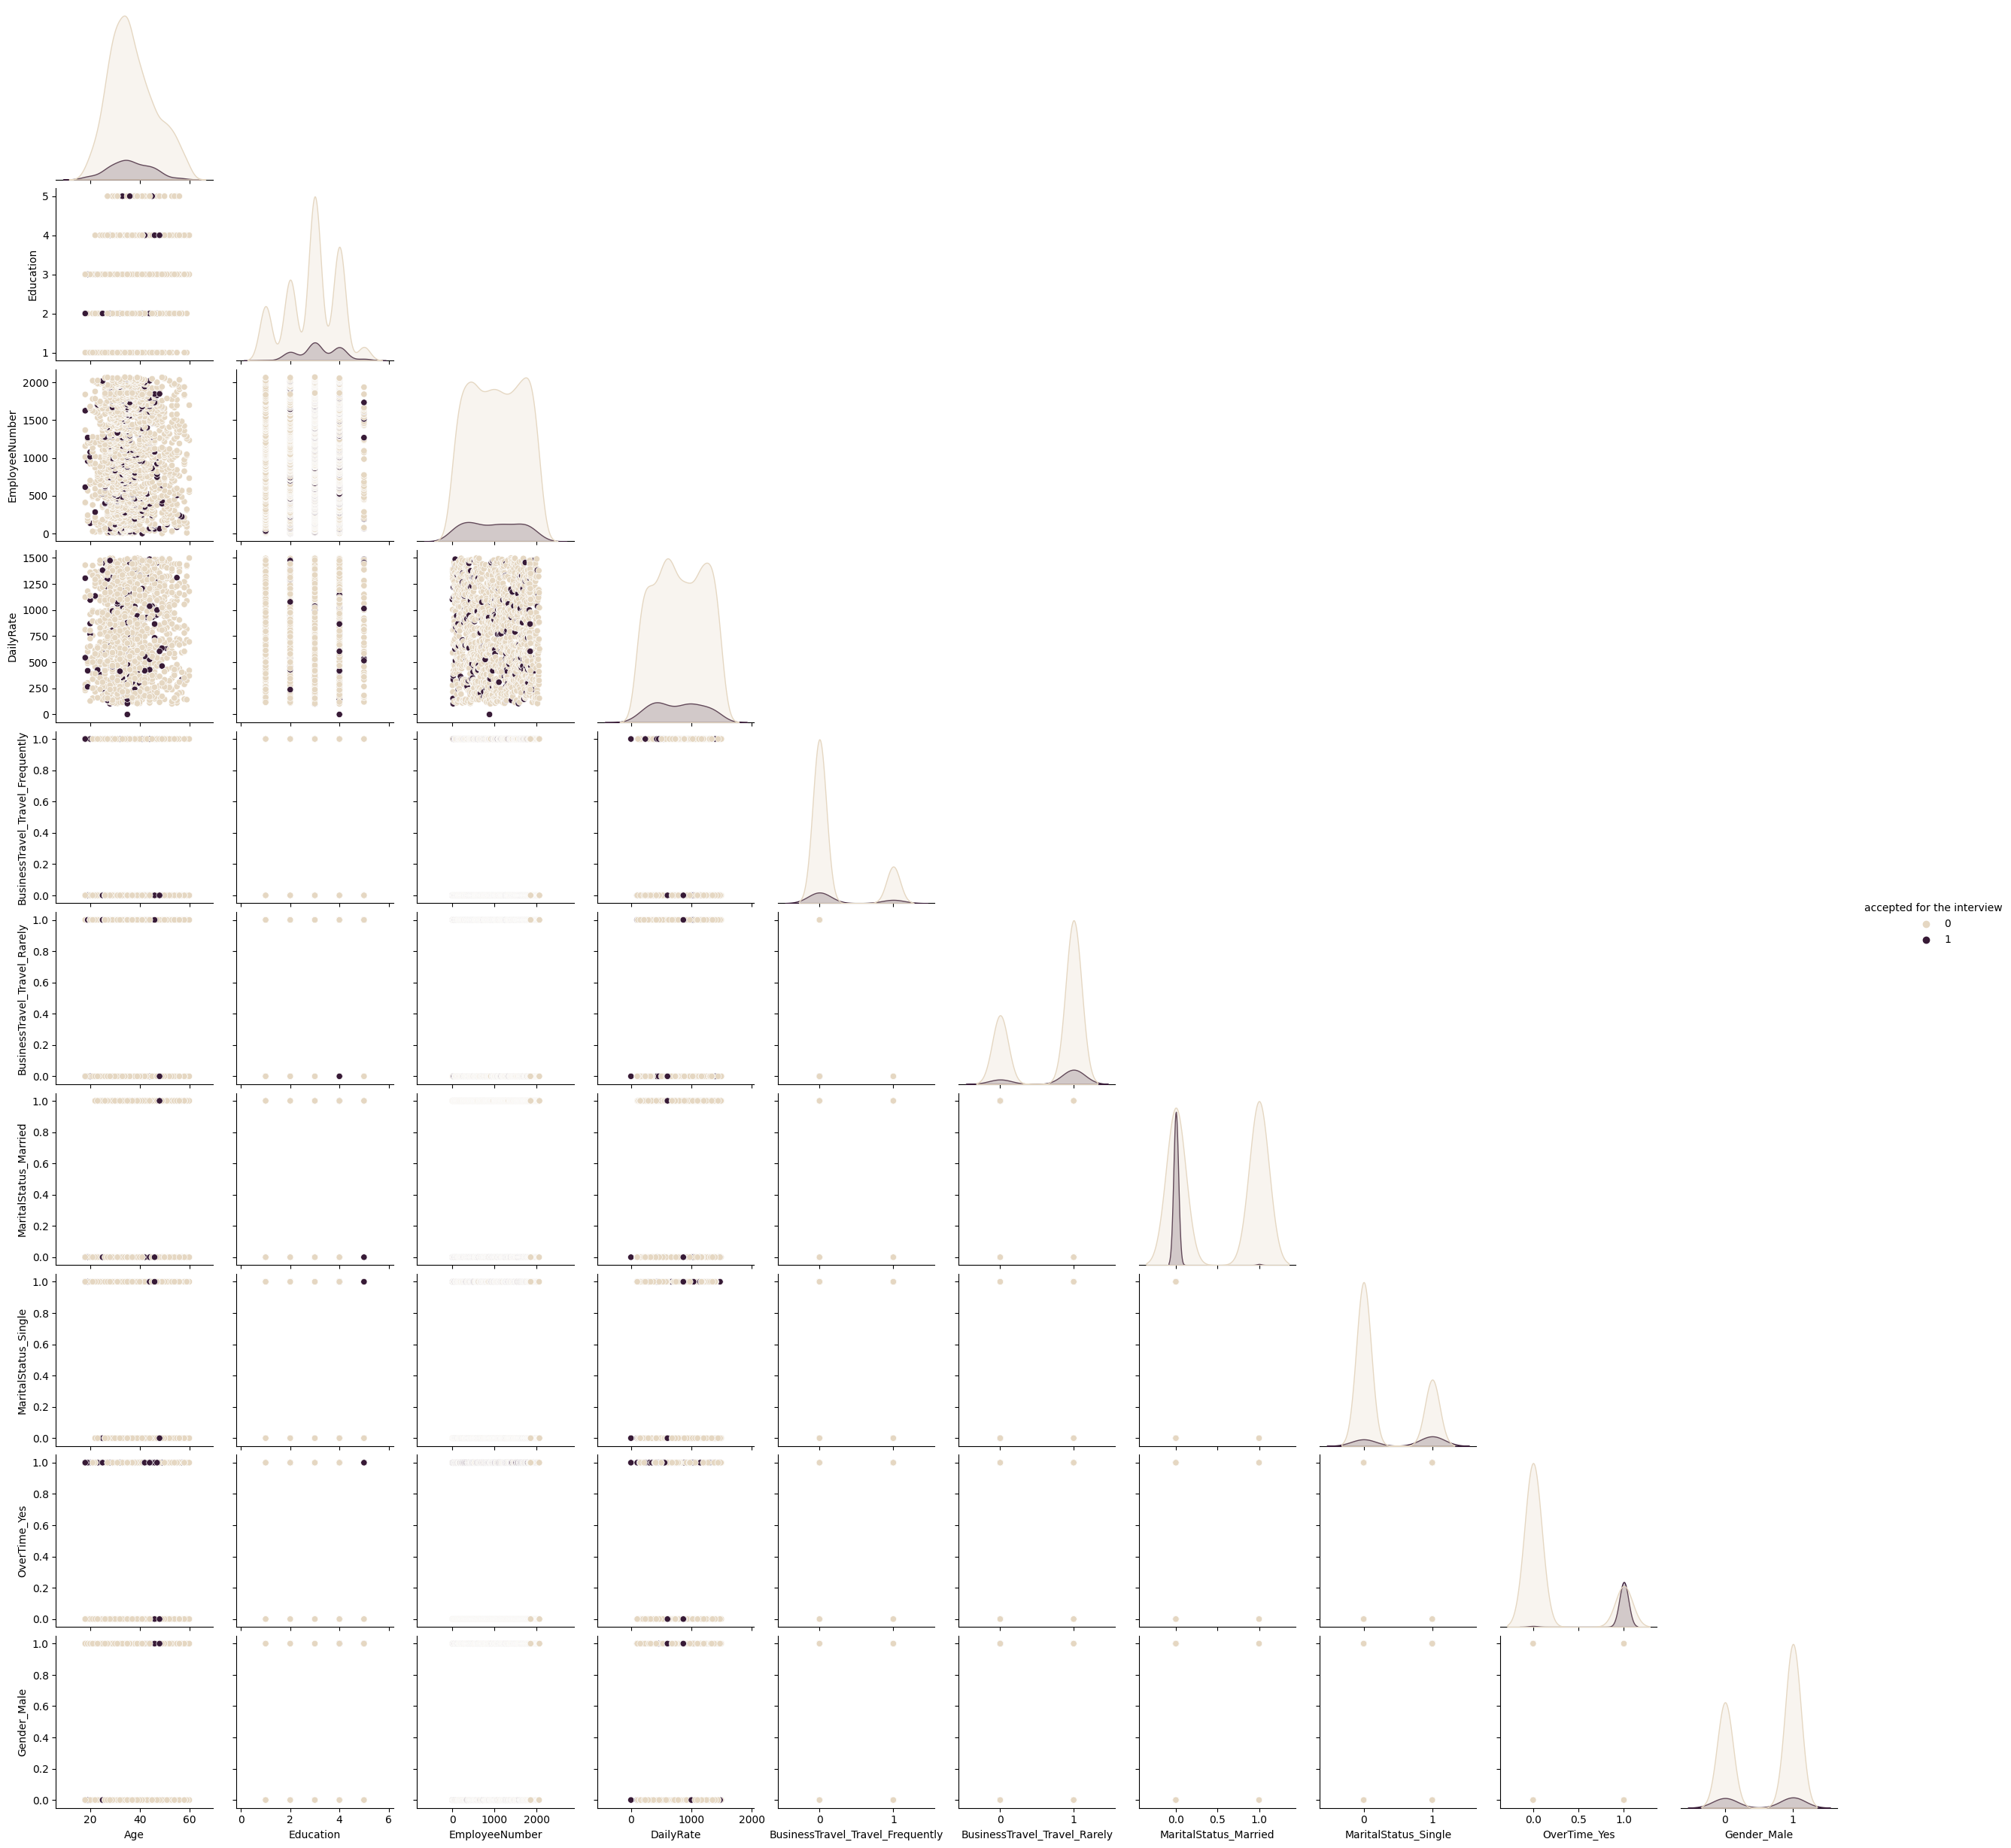

In [ ]:
sns.pairplot(df, corner=True, palette="ch:.25", hue="accepted for the interview")

From the above two plots, it's evident that our dataset was imbalanced, with the 'accepted for the interview' class having a significantly higher number of '0' labels compared to '1'. To address this imbalance, I utilized the SMOTE technique. With this resampling method in place, both classes in the target variable are now equally represented, which should lead to a more balanced training and potentially improved model performance.

In [ ]:
X = df.drop('accepted for the interview', axis=1)
y = df['accepted for the interview']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=42)

#**Model Building and Evaluation**

**Grid search was used to optimize the hyperparameters for all models (except Naive Bayes) and run the models with the appropriate parameters.**

##**Knn Classifier**

In [ ]:
param_grid = {
    'n_neighbors': [i for i in range(40)],
    'metric': ['minkowski', 'euclidean', 'manhattan']
}

knn = KNeighborsClassifier(weights = 'distance')

grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best accuracy:", best_score)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 3}
Best accuracy: 0.7427429072187535


In [ ]:
model_knn = KNeighborsClassifier(n_neighbors = 3, metric = 'manhattan',weights = 'distance')
model_knn.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

In [ ]:
cv_knn = cross_val_score(estimator = model_knn, X = X_train, y = y_train, cv = 5)
print("CV: ", cv_knn.mean())

y_pred_knn_train = model_knn.predict(X_train)
accuracy_knn_train = accuracy_score(y_train, y_pred_knn_train)
print("Training set: ", accuracy_knn_train)

y_pred_knn_test = model_knn.predict(X_test)
accuracy_knn_test = accuracy_score(y_test, y_pred_knn_test)
print("Test set: ", accuracy_knn_test)

CV:  0.7427429072187535
Training set:  1.0
Test set:  0.782312925170068


In [ ]:
pred_knn = model_knn.predict(X_test)
print(classification_report(y_test, pred_knn))

              precision    recall  f1-score   support

           0       0.86      0.67      0.76       443
           1       0.73      0.89      0.80       439

    accuracy                           0.78       882
   macro avg       0.80      0.78      0.78       882
weighted avg       0.80      0.78      0.78       882



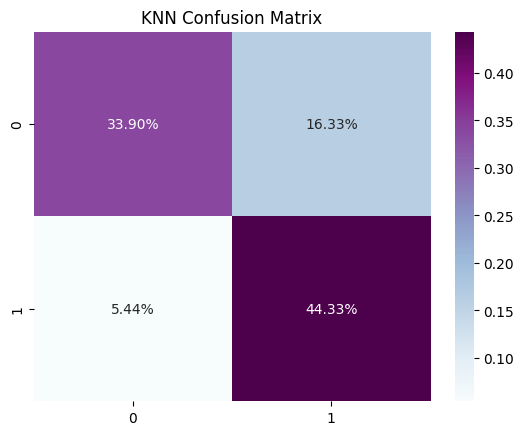

In [ ]:
cm1 = confusion_matrix(y_test, pred_knn)
sns.heatmap(cm1/np.sum(cm1), annot = True, fmt=  '0.2%', cmap = 'BuPu')
plt.title("KNN Confusion Matrix", fontsize=12)
plt.show()

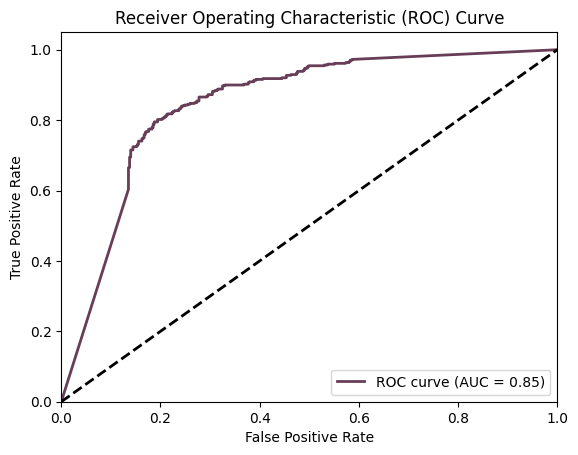

In [ ]:
y_prob_knn = model_knn.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_knn)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='#673d57', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


##**Naive Bayes Classifier**

In [ ]:
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)

GaussianNB()

In [ ]:
cv_nb = cross_val_score(estimator = model_nb, X = X_train, y = y_train, cv = 5)
print("CV: ", cv_nb.mean())

y_pred_nb_train = model_nb.predict(X_train)
accuracy_nb_train = accuracy_score(y_train, y_pred_nb_train)
print("Training set: ", accuracy_nb_train)

y_pred_nb_test = model_nb.predict(X_test)
accuracy_nb_test = accuracy_score(y_test, y_pred_nb_test)
print("Test set: ", accuracy_nb_test)

CV:  0.9485470165719919
Training set:  0.9513422818791947
Test set:  0.9580498866213152


In [ ]:
pred_nb = model_nb.predict(X_test)
print(classification_report(y_test, pred_nb))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       443
           1       0.96      0.96      0.96       439

    accuracy                           0.96       882
   macro avg       0.96      0.96      0.96       882
weighted avg       0.96      0.96      0.96       882



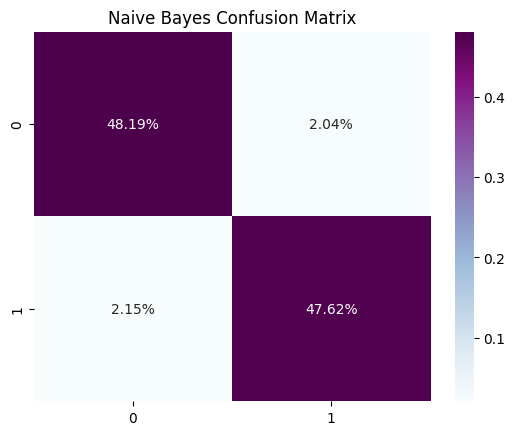

In [ ]:
cm2 = confusion_matrix(y_test, pred_nb)
sns.heatmap(cm2/np.sum(cm2), annot = True, fmt=  '0.2%', cmap = 'BuPu')
plt.title("Naive Bayes Confusion Matrix", fontsize=12)
plt.show()

##**Logistic Regression**

In [ ]:
param_grid = {
    'penalty': ['l1', 'l2'],  # Regularization penalty ('l1' for L1 regularization, 'l2' for L2 regularization)
    'C': [0.1, 1.0, 10.0],  # Inverse of regularization strength
    'fit_intercept': [True, False],  # Whether to calculate the intercept
    'solver': ['liblinear']  # Solver algorithm for optimization
}

logistic_regression = LogisticRegression()

grid_search = GridSearchCV(logistic_regression, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best score:", best_score)

Best parameters: {'C': 1.0, 'fit_intercept': False, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.9491041109181102


In [ ]:
model_LR=LogisticRegression(max_iter=1000, C = 1.0, fit_intercept = False, penalty= "l1", solver= 'liblinear')
model_LR.fit(X_train, y_train)

LogisticRegression(fit_intercept=False, max_iter=1000, penalty='l1',
                   solver='liblinear')

In [ ]:
cv_lr = cross_val_score(estimator = model_LR, X = X_train, y = y_train, cv = 5)
print("CV: ", cv_lr.mean())

y_pred_lr_train = model_LR.predict(X_train)
accuracy_lr_train = accuracy_score(y_train, y_pred_lr_train)
print("Training set: ", accuracy_lr_train)

y_pred_lr_test = model_LR.predict(X_test)
accuracy_lr_test = accuracy_score(y_test, y_pred_lr_test)
print("Test set: ", accuracy_lr_test)

CV:  0.9491041109181102
Training set:  0.9491051454138703
Test set:  0.953514739229025


In [ ]:
pred_LR = model_LR.predict(X_test)
print(classification_report(y_test, pred_LR))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       443
           1       0.95      0.96      0.95       439

    accuracy                           0.95       882
   macro avg       0.95      0.95      0.95       882
weighted avg       0.95      0.95      0.95       882



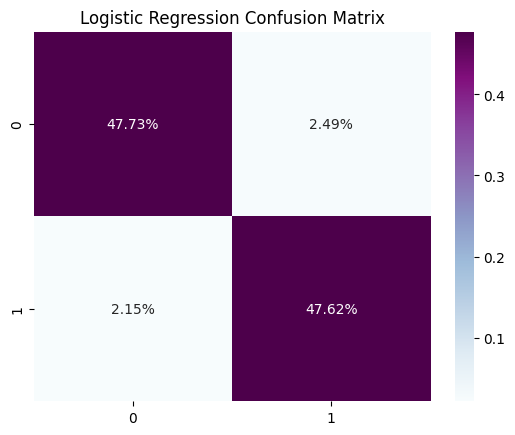

In [ ]:
cm3 = confusion_matrix(y_test, pred_LR)
sns.heatmap(cm3/np.sum(cm3), annot = True, fmt=  '0.2%', cmap = 'BuPu')
plt.title("Logistic Regression Confusion Matrix", fontsize=12)
plt.show()

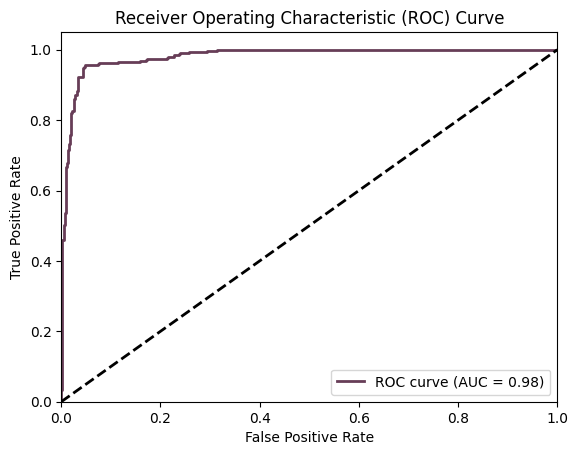

In [ ]:
y_prob_LR = model_LR.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_LR)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='#673d57', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

##**Random Forest Classifier**

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [3, 6, 9, None],  # Maximum depth of the trees
    'criterion': ['gini', 'entropy']  # Split criterion
}

rf_classifier = RandomForestClassifier()

grid_search = GridSearchCV(rf_classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best accuracy:", best_score)

Best parameters: {'criterion': 'gini', 'max_depth': None, 'n_estimators': 300}
Best accuracy: 0.9753876969782327


In [ ]:
model_rf = RandomForestClassifier(criterion='gini', n_estimators=300, max_depth=None)
model_rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300)

In [ ]:
cv_rf = cross_val_score(estimator = model_rf, X = X_train, y = y_train, cv = 5)
print("CV: ", cv_rf.mean())

y_pred_rf_train = model_rf.predict(X_train)
accuracy_rf_train = accuracy_score(y_train, y_pred_rf_train)
print("Training set: ", accuracy_rf_train)

y_pred_rf_test = model_rf.predict(X_test)
accuracy_rf_test = accuracy_score(y_test, y_pred_rf_test)
print("Test set: ", accuracy_rf_test)

CV:  0.9725928360170885
Training set:  1.0
Test set:  0.9886621315192744


In [ ]:
pred_rf = model_rf.predict(X_test)
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       443
           1       0.98      0.99      0.99       439

    accuracy                           0.99       882
   macro avg       0.99      0.99      0.99       882
weighted avg       0.99      0.99      0.99       882



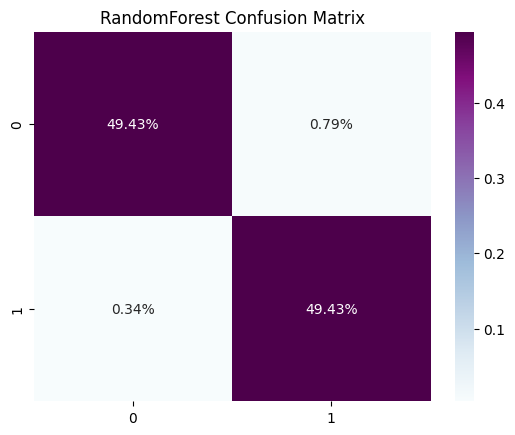

In [ ]:
cm4 = confusion_matrix(y_test, pred_rf)
sns.heatmap(cm4/np.sum(cm4), annot = True, fmt=  '0.2%', cmap = 'BuPu')
plt.title("RandomForest Confusion Matrix", fontsize=12)
plt.show()

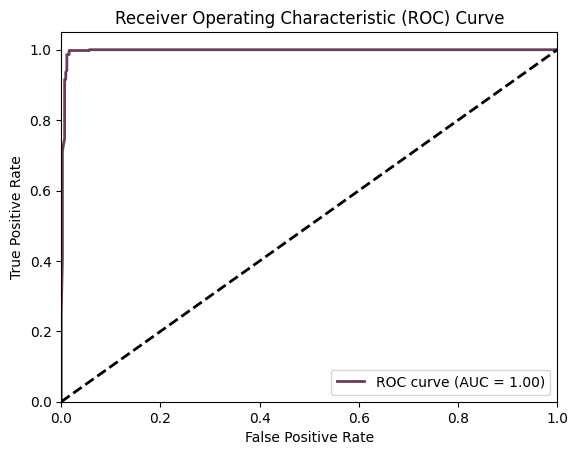

In [ ]:
y_prob_rf = model_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='#673d57', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

##**AdaBoost Classifier**

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of estimators (weak learners)
    'learning_rate': [0.1, 0.5, 1.0]  # Learning rate
}

ada = AdaBoostClassifier()
grid_search = GridSearchCV(ada, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'learning_rate': 1.0, 'n_estimators': 50}
Best Score:  0.9658748415567345


In [ ]:
model_ada = AdaBoostClassifier(learning_rate= 1.0, n_estimators= 50)
model_ada.fit(X_train, y_train)

AdaBoostClassifier()

In [ ]:
cv_ada = cross_val_score(estimator = model_ada, X = X_train, y = y_train, cv = 5)
print("CV: ", cv_ada.mean())

y_pred_ada_train = model_ada.predict(X_train)
accuracy_ada_train = accuracy_score(y_train, y_pred_ada_train)
print("Training set: ", accuracy_ada_train)

y_pred_ada_test = model_ada.predict(X_test)
accuracy_ada_test = accuracy_score(y_test, y_pred_ada_test)
print("Test set: ", accuracy_ada_test)

CV:  0.9658748415567345
Training set:  0.9737136465324385
Test set:  0.971655328798186


In [ ]:
pred_ada = model_ada.predict(X_test)
print(classification_report(y_test, pred_ada))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       443
           1       0.97      0.97      0.97       439

    accuracy                           0.97       882
   macro avg       0.97      0.97      0.97       882
weighted avg       0.97      0.97      0.97       882



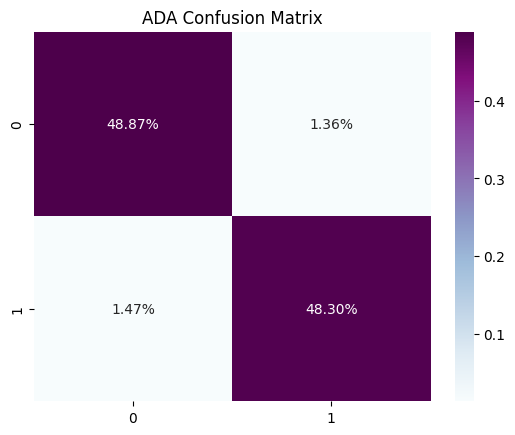

In [ ]:
cm5 = confusion_matrix(y_test, pred_ada)
sns.heatmap(cm5/np.sum(cm5), annot = True, fmt=  '0.2%', cmap = 'BuPu')
plt.title("ADA Confusion Matrix", fontsize=12)
plt.show()

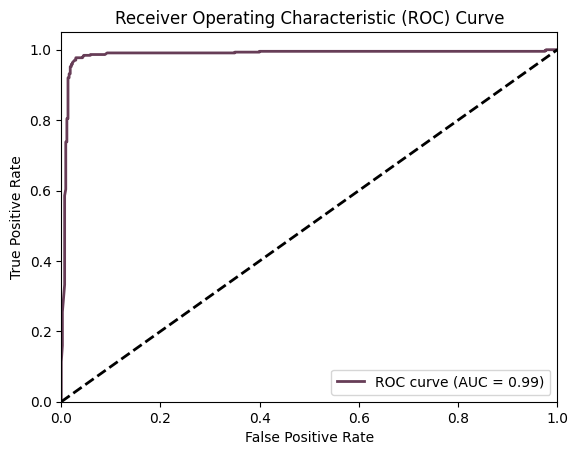

In [ ]:
y_prob_ada = model_ada.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_ada)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='#673d57', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## **Decision Tree Classifier**

In [ ]:
param_grid = {
    'max_depth': range(3,9),  # Maximum depth of the tree
    'criterion': ['gini', 'entropy']  # Split criterion
}

dt_classifier = DecisionTreeClassifier()

grid_search = GridSearchCV(dt_classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best accuracy:", best_score)

Best parameters: {'criterion': 'gini', 'max_depth': 8}
Best accuracy: 0.9619689216468711


In [ ]:
model_dt = DecisionTreeClassifier(criterion= 'gini', max_depth = 8)
model_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8)

In [ ]:
cv_dt = cross_val_score(estimator = model_dt, X = X_train, y = y_train, cv = 5)
print("CV: ", cv_dt.mean())

y_pred_dt_train = model_dt.predict(X_train)
accuracy_dt_train = accuracy_score(y_train, y_pred_dt_train)
print("Training set: ", accuracy_dt_train)

y_pred_dt_test = model_dt.predict(X_test)
accuracy_dt_test = accuracy_score(y_test, y_pred_dt_test)
print("Test set: ", accuracy_dt_test)

CV:  0.9597311550318451
Training set:  0.9876957494407159
Test set:  0.9784580498866213


In [ ]:
pred_dt = model_dt.predict(X_test)
print(classification_report(y_test, pred_dt))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       443
           1       0.97      0.99      0.98       439

    accuracy                           0.98       882
   macro avg       0.98      0.98      0.98       882
weighted avg       0.98      0.98      0.98       882



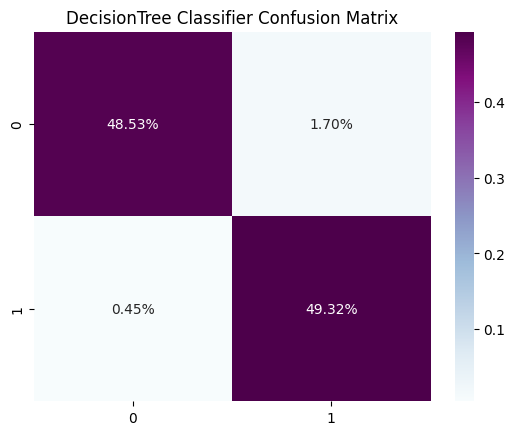

In [ ]:
cm7 = confusion_matrix(y_test, pred_dt)
sns.heatmap(cm7/np.sum(cm7), annot = True, fmt=  '0.2%', cmap = 'BuPu')
plt.title("DecisionTree Classifier Confusion Matrix",fontsize=12)
plt.show()

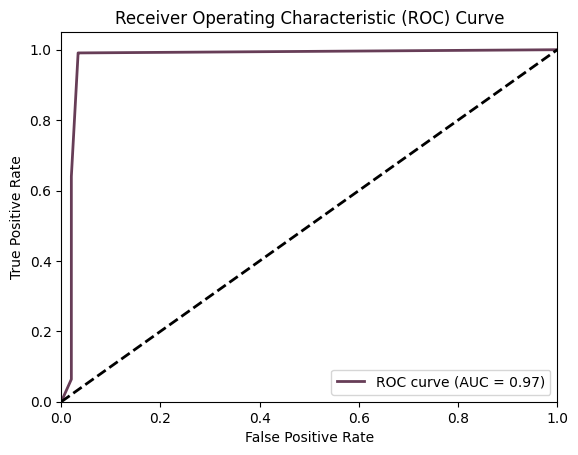

In [ ]:
y_prob_dt = model_dt.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_dt)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='#673d57', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## **XGBoost Classifier**

In [ ]:
model_xgb = XGBClassifier(max_depth= 8, n_estimators= 125, random_state= 0,  learning_rate= 0.03, n_jobs=5)
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=125, n_jobs=5, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

In [ ]:
cv_xgb = cross_val_score(estimator = model_xgb, X = X_train, y = y_train, cv = 5)
print("CV: ", cv_xgb.mean())

y_pred_xgb_train = model_xgb.predict(X_train)
accuracy_xgb_train = accuracy_score(y_train, y_pred_xgb_train)
print("Training set: ", accuracy_xgb_train)

y_pred_xgb_test = model_xgb.predict(X_test)
accuracy_xgb_test = accuracy_score(y_test, y_pred_xgb_test)
print("Test set: ", accuracy_xgb_test)

CV:  0.9658857956590458
Training set:  0.9854586129753915
Test set:  0.9829931972789115


In [ ]:
pred_xgb = model_xgb.predict(X_test)
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       443
           1       0.97      1.00      0.98       439

    accuracy                           0.98       882
   macro avg       0.98      0.98      0.98       882
weighted avg       0.98      0.98      0.98       882



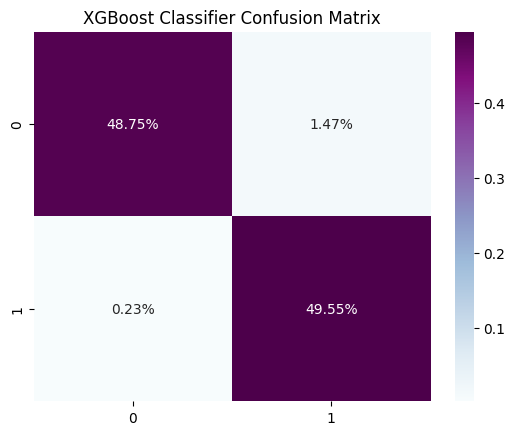

In [ ]:
cm8 = confusion_matrix(y_test, pred_xgb)
sns.heatmap(cm8/np.sum(cm8), annot = True, fmt=  '0.2%', cmap = 'BuPu')
plt.title("XGBoost Classifier Confusion Matrix",fontsize=12)
plt.show()

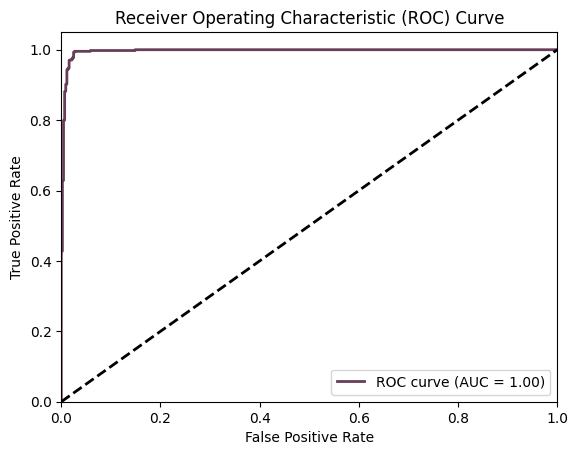

In [ ]:
y_prob_xgb = model_xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_xgb)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='#673d57', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## **Bagging Classifier**

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of base estimators
    'max_samples': [0.5, 0.7, 1.0],  # Proportion of samples to draw from the training set
    'max_features': [0.5, 0.7, 1.0],  # Proportion of features to draw from the training set
    'bootstrap': [True, False],  # Whether to bootstrap samples
    'bootstrap_features': [True, False],  # Whether to bootstrap features
    'base_estimator': [DecisionTreeClassifier(max_depth=5), DecisionTreeClassifier(max_depth=10)]  # Base estimator
}
bg_classifier = BaggingClassifier()

grid_search = GridSearchCV(bg_classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best accuracy:", best_score)

Best parameters: {'base_estimator': DecisionTreeClassifier(max_depth=10), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 0.7, 'max_samples': 0.5, 'n_estimators': 50}
Best accuracy: 0.9770683692471402


In [ ]:
model_bg = BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth=10), bootstrap= True, bootstrap_features= False, max_features=0.7, max_samples= 0.5, n_estimators= 50)
model_bg.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                  max_features=0.7, max_samples=0.5, n_estimators=50)

In [ ]:
cv_bg = cross_val_score(estimator = model_bg, X = X_train, y = y_train, cv = 5)
print("CV: ", cv_bg.mean())

y_pred_bg_train = model_bg.predict(X_train)
accuracy_bg_train = accuracy_score(y_train, y_pred_bg_train)
print("Training set: ", accuracy_bg_train)

y_pred_bg_test = model_bg.predict(X_test)
accuracy_bg_test = accuracy_score(y_test, y_pred_bg_test)
print("Test set: ", accuracy_bg_test)

CV:  0.974267248798961
Training set:  0.9865771812080537
Test set:  0.9841269841269841


In [ ]:
pred_bg = model_bg.predict(X_test)
print(classification_report(y_test, pred_bg))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       443
           1       0.98      0.99      0.98       439

    accuracy                           0.98       882
   macro avg       0.98      0.98      0.98       882
weighted avg       0.98      0.98      0.98       882



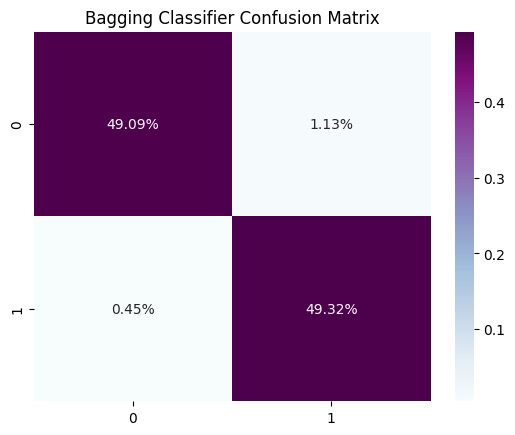

In [ ]:
cm9 = confusion_matrix(y_test, pred_bg)
sns.heatmap(cm9/np.sum(cm9), annot = True, fmt=  '0.2%', cmap = 'BuPu')
plt.title("Bagging Classifier Confusion Matrix",fontsize=12)
plt.show()

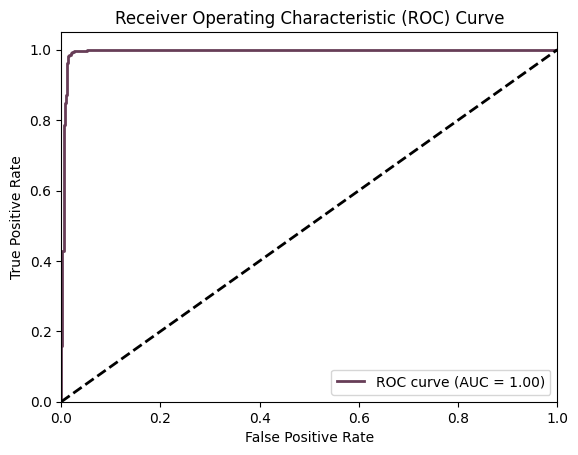

In [ ]:
y_prob_bg = model_bg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_bg)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='#673d57', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## **Voting Classifier**

In [ ]:
log_reg = LogisticRegression()
svm = SVC(probability=True)
dt = DecisionTreeClassifier()

voting = VotingClassifier(
    estimators=[('lr', log_reg), ('svm', svm), ('dt', dt)],
    voting='soft'
)

param_grid = {
    'lr__C': [0.1, 1.0, 10.0],  # C parameter for Logistic Regression
    'svm__C': [0.1, 1.0, 10.0],  # C parameter for SVM
    'dt__max_depth': [3, 5, None]  # Maximum depth for Decision Tree
}

grid_search = GridSearchCV(voting, param_grid, cv=5)
grid_search.fit(X, y)

print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


Best Parameters:  {'dt__max_depth': None, 'lr__C': 10.0, 'svm__C': 0.1}
Best Score:  0.9738591726336109


In [ ]:
log_reg = LogisticRegression(C=10)
svm = SVC(C=0.1, probability=True)
dt = DecisionTreeClassifier(max_depth=None)

model_vot = VotingClassifier(
    estimators=[('lr', log_reg), ('svm', svm), ('dt', dt)],
    voting='soft'
)

In [ ]:
model_vot.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=10)),
                             ('svm', SVC(C=0.1, probability=True)),
                             ('dt', DecisionTreeClassifier())],
                 voting='soft')

In [ ]:
cv_vot = cross_val_score(estimator = model_vot, X = X_train, y = y_train, cv = 5)
print("CV: ", cv_vot.mean())

y_pred_vot_train = model_vot.predict(X_train)
accuracy_vot_train = accuracy_score(y_train, y_pred_vot_train)
print("Training set: ", accuracy_vot_train)

y_pred_vot_test = model_vot.predict(X_test)
accuracy_vot_test = accuracy_score(y_test, y_pred_vot_test)
print("Test set: ", accuracy_vot_test)

CV:  0.9569362940707009
Training set:  0.9966442953020134
Test set:  0.9682539682539683


In [ ]:
pred_vot = model_vot.predict(X_test)
print(classification_report(y_test, pred_vot))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       443
           1       0.96      0.97      0.97       439

    accuracy                           0.97       882
   macro avg       0.97      0.97      0.97       882
weighted avg       0.97      0.97      0.97       882



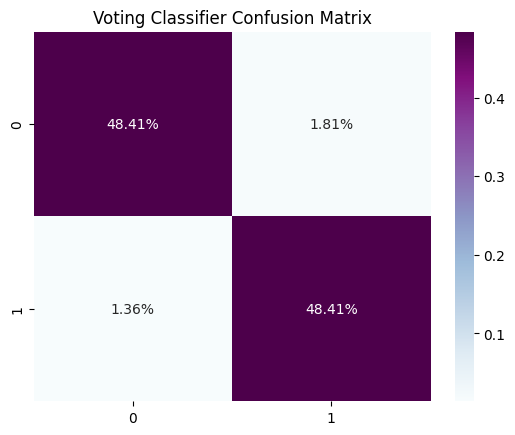

In [ ]:
cm10 = confusion_matrix(y_test, pred_vot)
sns.heatmap(cm10/np.sum(cm10), annot = True, fmt=  '0.2%', cmap = 'BuPu')
plt.title("Voting Classifier Confusion Matrix",fontsize=12)
plt.show()

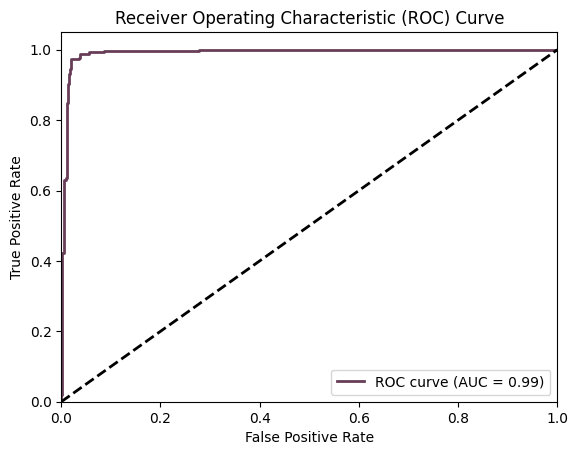

In [ ]:
y_prob_vot = model_vot.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_vot)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='#673d57', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## **Stacking Classifier**

In [ ]:
log_reg = LogisticRegression()
svm = SVC(probability=True)
dt = DecisionTreeClassifier()

stacking = StackingClassifier(
    estimators=[('lr', log_reg), ('svm', svm), ('dt', dt)],
    final_estimator=LogisticRegression()
)

param_grid = {
    'lr__C': [0.1, 1.0, 10.0],  # C parameter for Logistic Regression
    'svm__C': [0.1, 1.0, 10.0],  # C parameter for SVM
    'dt__max_depth': [3, 5, None],  # Maximum depth for Decision Tree
    'final_estimator__C': [0.1, 1.0, 10.0]  # C parameter for the final estimator
}

grid_search = GridSearchCV(stacking, param_grid, cv=5)
grid_search.fit(X, y)

print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


Best Parameters:  {'dt__max_depth': None, 'final_estimator__C': 0.1, 'lr__C': 0.1, 'svm__C': 0.1}
Best Score:  0.9825817602298489


In [ ]:
log_reg = LogisticRegression(C=0.1)
svm = SVC(C=0.1, probability=True)
dt = DecisionTreeClassifier(max_depth=None)

model_stack = StackingClassifier(
    estimators=[('lr', log_reg), ('svm', svm), ('dt', dt)],
    final_estimator=LogisticRegression(C=0.1)
)

In [ ]:
model_stack.fit(X_train, y_train)

StackingClassifier(estimators=[('lr', LogisticRegression(C=0.1)),
                               ('svm', SVC(C=0.1, probability=True)),
                               ('dt', DecisionTreeClassifier())],
                   final_estimator=LogisticRegression(C=0.1))

In [ ]:
cv_stack = cross_val_score(estimator = model_stack, X = X_train, y = y_train, cv = 5)
print("CV: ", cv_stack.mean())

y_pred_stack_train = model_stack.predict(X_train)
accuracy_stack_train = accuracy_score(y_train, y_pred_stack_train)
print("Training set: ", accuracy_stack_train)

y_pred_stack_test = model_stack.predict(X_test)
accuracy_stack_test = accuracy_score(y_test, y_pred_stack_test)
print("Test set: ", accuracy_stack_test)

CV:  0.9558142810196705
Training set:  1.0
Test set:  0.9682539682539683


In [ ]:
pred_stack = model_stack.predict(X_test)
print(classification_report(y_test, pred_stack))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       443
           1       0.96      0.97      0.97       439

    accuracy                           0.97       882
   macro avg       0.97      0.97      0.97       882
weighted avg       0.97      0.97      0.97       882



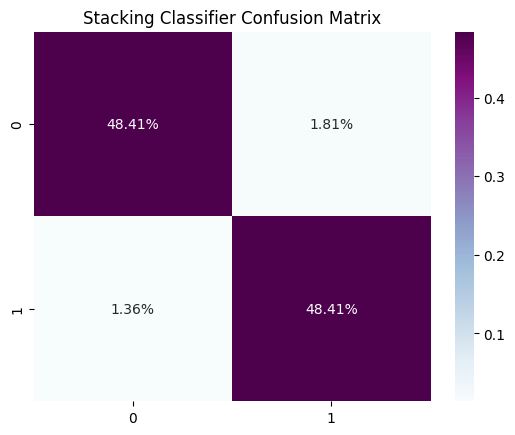

In [ ]:
cm11 = confusion_matrix(y_test, pred_stack)
sns.heatmap(cm11/np.sum(cm11), annot = True, fmt=  '0.2%', cmap = 'BuPu')
plt.title("Stacking Classifier Confusion Matrix",fontsize=12)
plt.show()

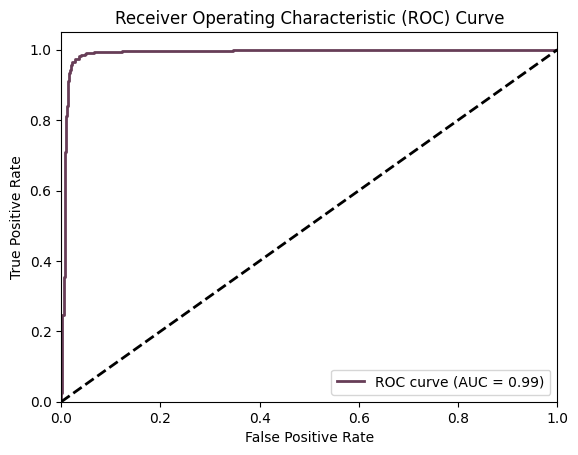

In [ ]:
y_prob_stack = model_stack.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_stack)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='#673d57', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# **Final report**

In [ ]:
output = pd.DataFrame({"Model":['KNN Classifier','Naive-Bayes','Logistic Regression',
                                'Random Forest Classifier','AdaBoost Classifier',
                               'Decision Tree Classifier','XGB Classifier','Bagging Classifier',
                               'Voting Classifier','Stacking Classifier'],
                      "Accuracy":[accuracy_knn_test, accuracy_nb_test, accuracy_lr_test, accuracy_rf_test, accuracy_ada_test,
                                 accuracy_dt_test, accuracy_xgb_test, accuracy_bg_test, accuracy_vot_test, accuracy_stack_test]})

In [ ]:
output

,Model,Accuracy
0,KNN Classifier,0.782313
1,Naive-Bayes,0.958050
2,Logistic Regression,0.953515
3,Random Forest Classifier,0.988662
4,AdaBoost Classifier,0.971655
5,Decision Tree Classifier,0.978458
6,XGB Classifier,0.982993
7,Bagging Classifier,0.984127
8,Voting Classifier,0.968254
9,Stacking Classifier,0.968254


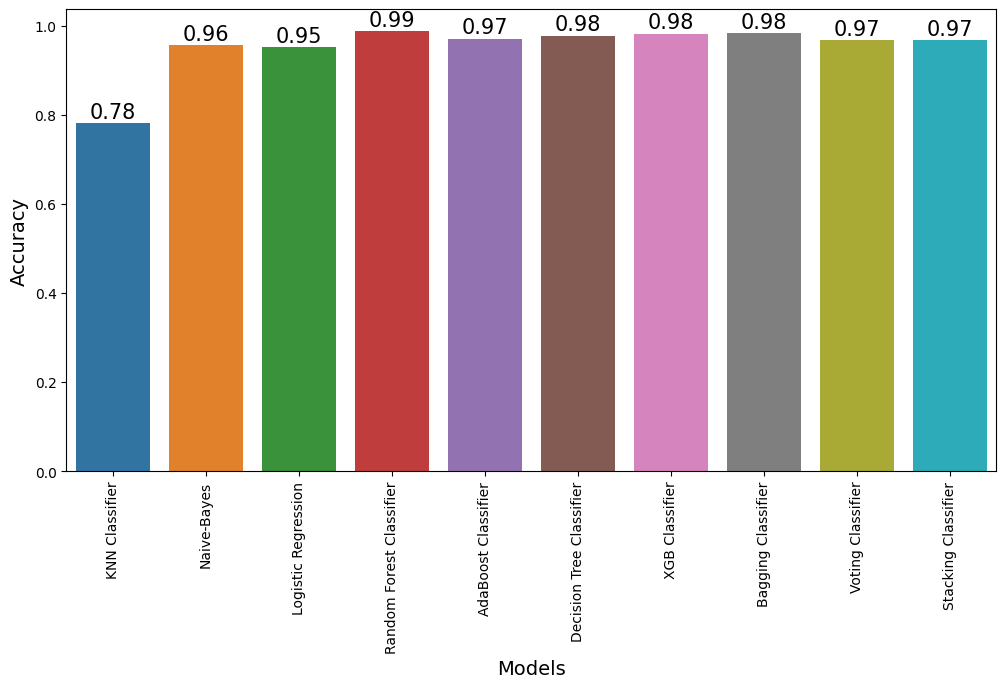

In [ ]:
plt.figure(figsize=(12, 6))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.xticks(rotation=90);
plt.ylabel("Accuracy", size=14)
plt.show()

Thus, the best option is given by Random Forest Classifier.